In [50]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import learning_curve
import numpy as np
drive.mount('/content/drive')

dataset = pd.read_csv("/content/drive/MyDrive/train.csv")

# Printing first 5 records of the dataset
print(dataset.head(5))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllP

In [4]:
dataset.shape


(1460, 81)

In [5]:
obj = (dataset.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))

int_ = (dataset.dtypes == 'int')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))

fl = (dataset.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))


Categorical variables: 43
Integer variables: 35
Float variables: 3


<Axes: >

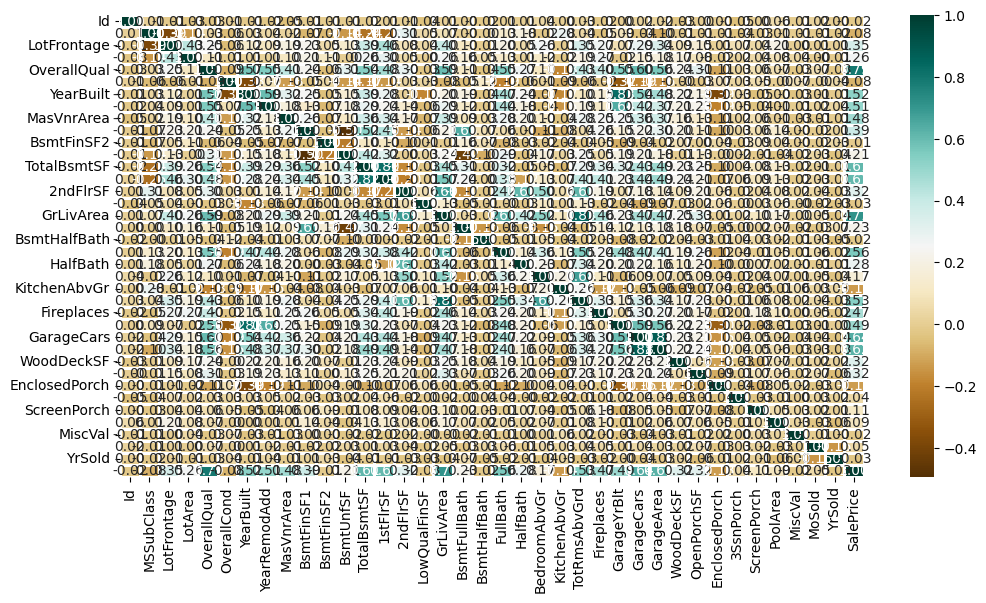

In [6]:
# Select only numerical features for correlation analysis
numerical_dataset = dataset.select_dtypes(include=['number'])

plt.figure(figsize=(12, 6))
sns.heatmap(numerical_dataset.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

<Axes: title={'center': 'No. Unique values of Categorical Features'}>

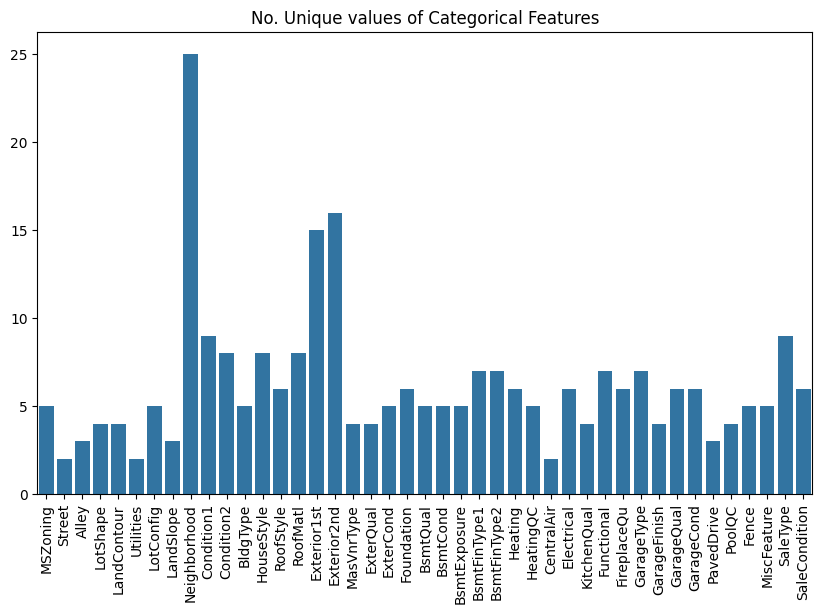

In [7]:
unique_values = []
for col in object_cols:
  unique_values.append(dataset[col].unique().size)
plt.figure(figsize=(10,6))
plt.title('No. Unique values of Categorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols,y=unique_values)

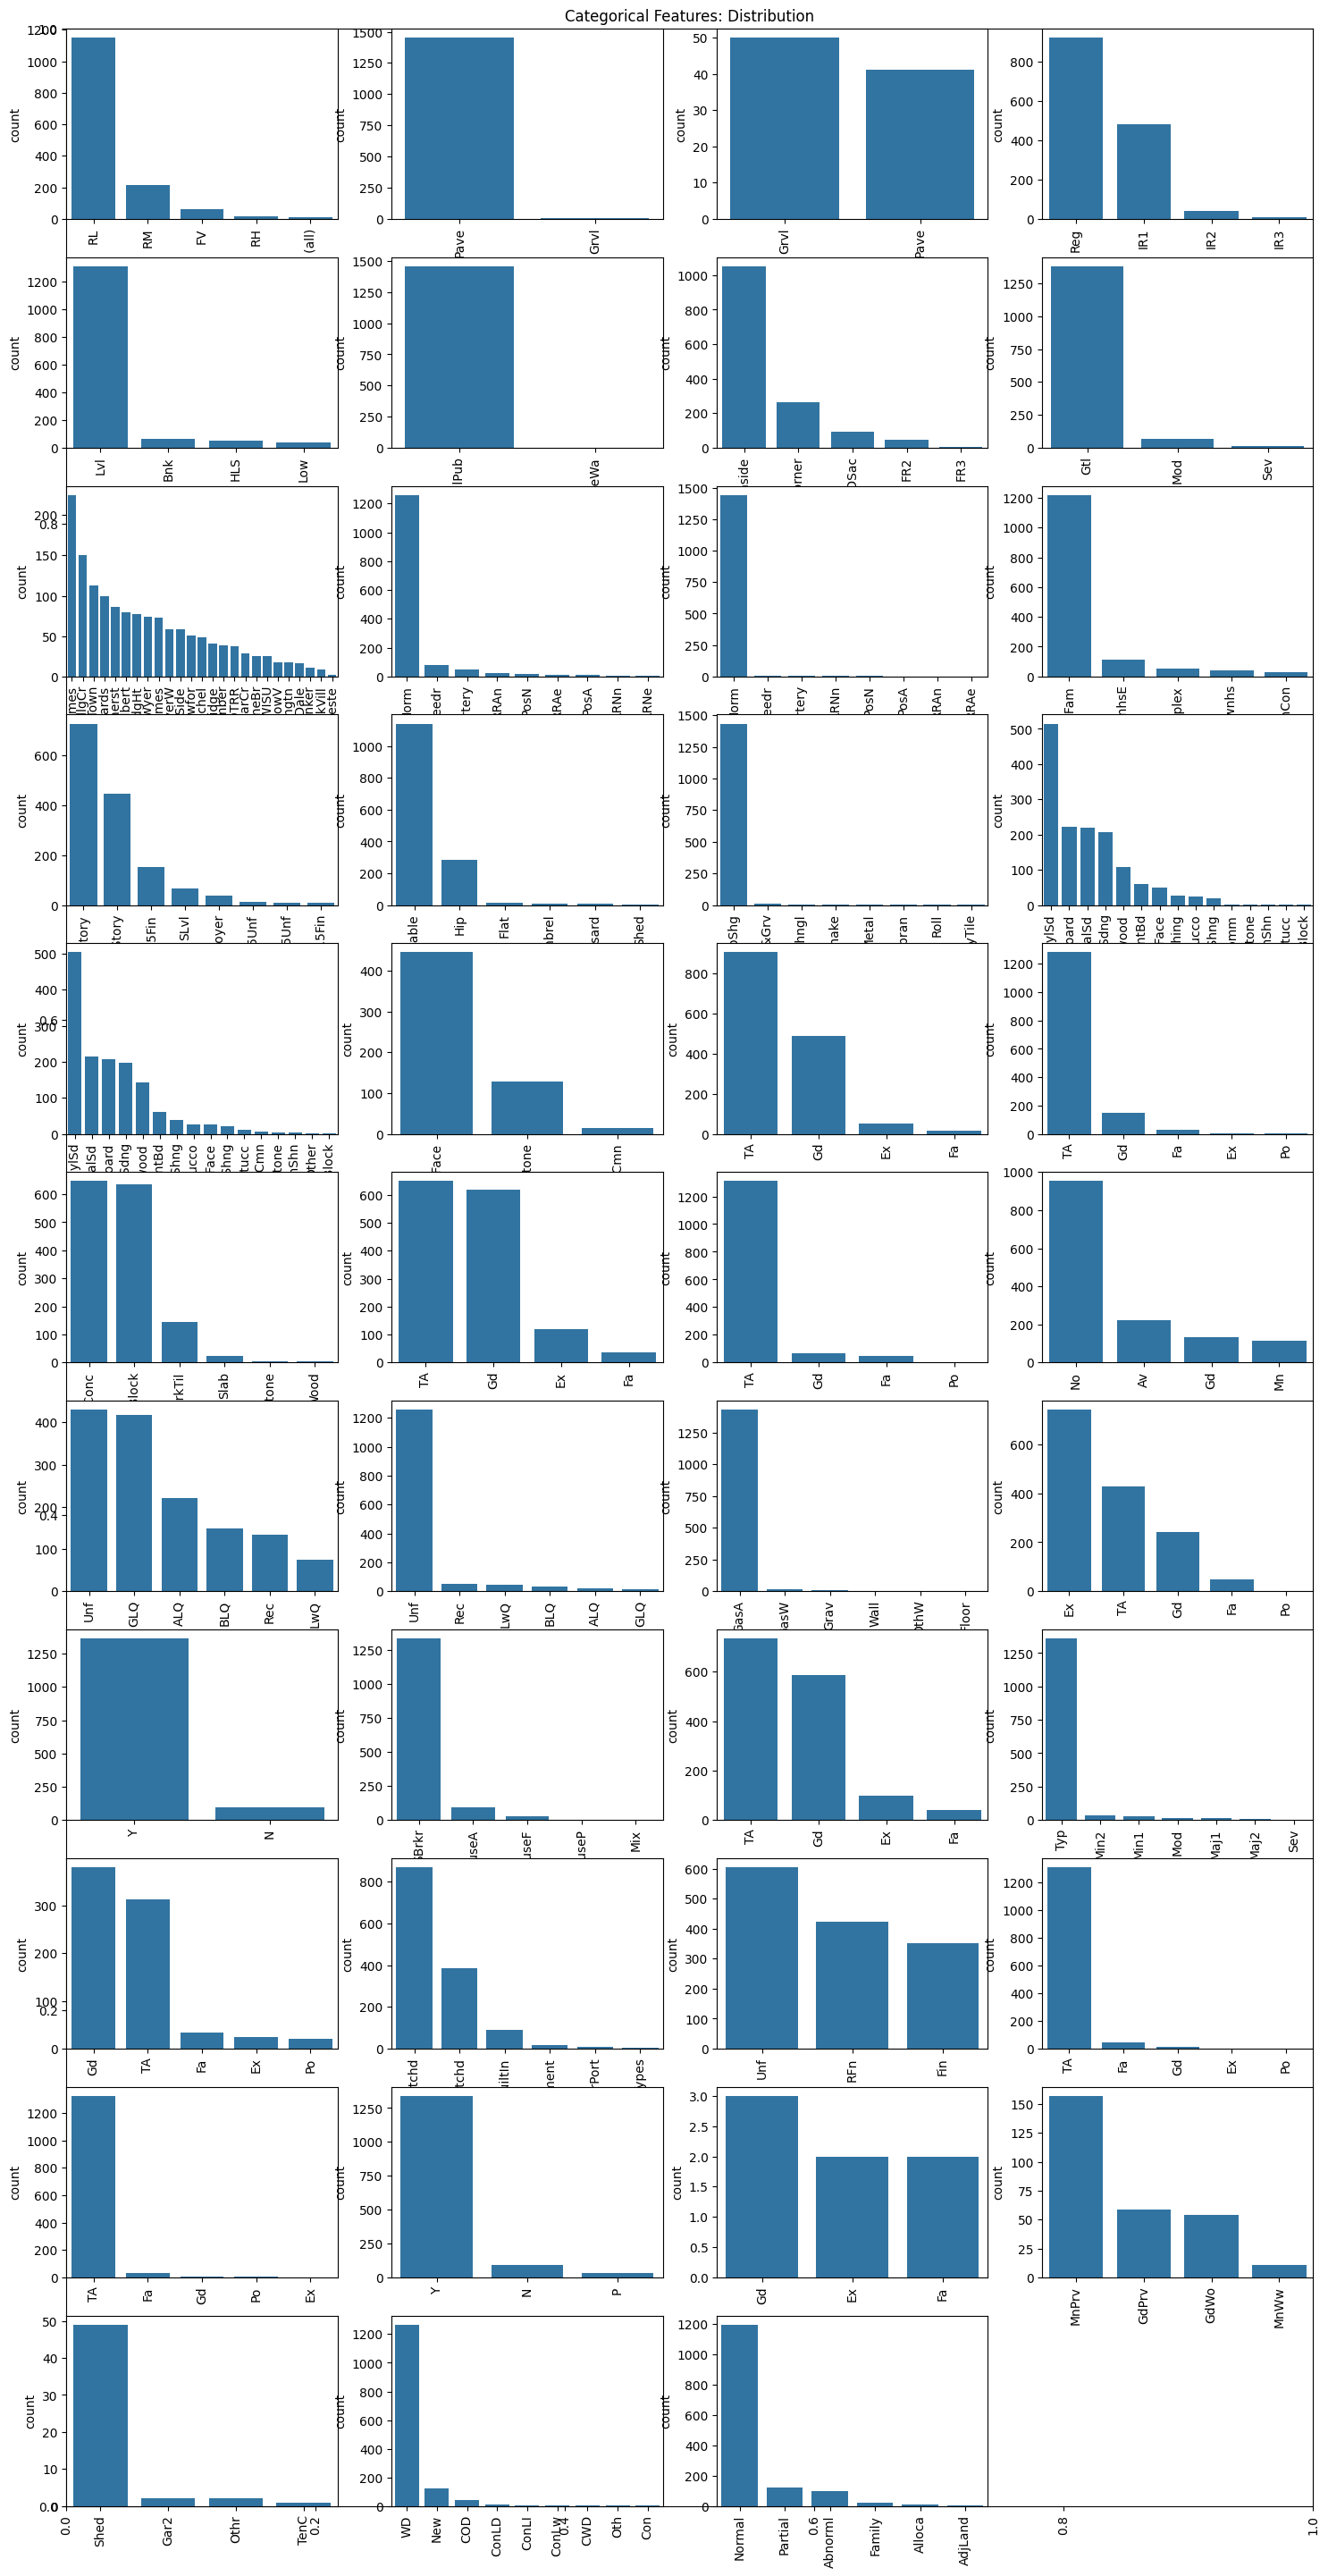

In [8]:
plt.figure(figsize=(18, 36))
plt.title('Categorical Features: Distribution')
plt.xticks(rotation=90)
index = 1

for col in object_cols:
	y = dataset[col].value_counts()
	plt.subplot(11, 4, index)
	plt.xticks(rotation=90)
	sns.barplot(x=list(y.index), y=y)
	index += 1


In [9]:
dataset.drop(['Id'],
			axis=1,
			inplace=True)


In [25]:
dataset['SalePrice'] = dataset['SalePrice'].fillna(
dataset['SalePrice'].mean())


In [26]:
new_dataset = dataset.dropna()


In [27]:
new_dataset.isnull().sum()


,0
MSSubClass,0
MSZoning,0
LotFrontage,0
LotArea,0
Street,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


In [13]:
from sklearn.preprocessing import OneHotEncoder

s = (new_dataset.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of. categorical features: ',
	len(object_cols))


Categorical variables:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
No. of. categorical features:  43


In [34]:
# Impute missing values in categorical columns with 'Missing'
for col in object_cols:
    dataset[col] = dataset[col].fillna('Missing')

# Drop rows with missing values in numerical columns (if any)
new_dataset = dataset.dropna(subset=[col for col in dataset.columns if col not in object_cols])

# One-hot encoding
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_dataset[object_cols]))
OH_cols.index = new_dataset.index
OH_cols.columns = OH_encoder.get_feature_names_out()
df_final = new_dataset.drop(object_cols, axis=1)
df_final = pd.concat([df_final, OH_cols], axis=1)

In [35]:
scaler = StandardScaler()
numeric_features = df_final.select_dtypes(include=['number']).columns
df_final[numeric_features] = scaler.fit_transform(df_final[numeric_features])


In [37]:
X = df_final.drop(columns=['SalePrice'])
y = df_final['SalePrice']
selector = SelectKBest(score_func=mutual_info_regression, k=10)  # Select top 10 features
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
df_final = df_final[selected_features]

In [40]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Split the training set into
# training and validation set
X_train, X_valid, Y_train, Y_valid = train_test_split(
	X, Y, train_size=0.8, test_size=0.2, random_state=0)


In [41]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_percentage_error

model_SVR = svm.SVR()
model_SVR.fit(X_train,Y_train)
Y_pred = model_SVR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.2985910726888312


In [42]:
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(n_estimators=10)
model_RFR.fit(X_train, Y_train)
Y_pred = model_RFR.predict(X_valid)

mean_absolute_percentage_error(Y_valid, Y_pred)

0.11208615951515194

In [43]:
from sklearn.linear_model import LinearRegression

model_LR = LinearRegression()
model_LR.fit(X_train, Y_train)
Y_pred = model_LR.predict(X_valid)

print(mean_absolute_percentage_error(Y_valid, Y_pred))

0.1235083982086892


In [45]:
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Define model
cb_model = CatBoostRegressor(silent=True)

# Define parameter grid for tuning
param_grid = {
    'iterations': [500, 1000],
    'depth': [6, 8],
    'learning_rate': [0.03, 0.1]
}

# Perform grid search
grid_search = GridSearchCV(cb_model, param_grid, scoring='r2', cv=3, n_jobs=-1)
grid_search.fit(X_train, Y_train)

# Get the best model
best_cb_model = grid_search.best_estimator_

# Predict and evaluate
preds = best_cb_model.predict(X_valid)
cb_r2_score = r2_score(Y_valid, preds)

# Print best parameters and R² score
print("Best Parameters:", grid_search.best_params_)
print("R² Score:", cb_r2_score)

Best Parameters: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.03}
R² Score: 0.8836715771540574


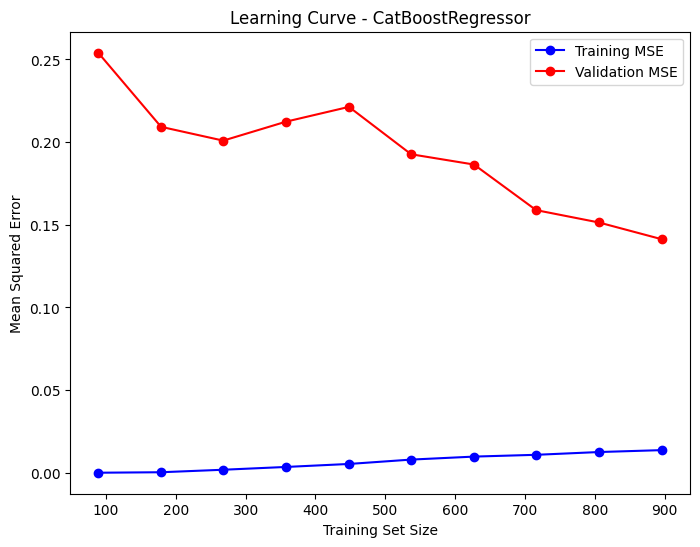

In [51]:
# Learning Curve Plot using CatBoostRegressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, loss_function='RMSE', verbose=0)
train_sizes, train_scores, val_scores = learning_curve(model, X_selected, y, cv=5, scoring='neg_mean_squared_error', train_sizes=np.linspace(0.1, 1.0, 10))

# Convert negative MSE scores to positive
train_scores_mean = -train_scores.mean(axis=1)
val_scores_mean = -val_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='blue', label='Training MSE')
plt.plot(train_sizes, val_scores_mean, 'o-', color='red', label='Validation MSE')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curve - CatBoostRegressor')
plt.legend()
plt.show()